**сеть Кохонена (SOM), кластеризация**

Евгений Борисов esborisov@sevsu.ru

Кластеризатор на основе нейронной сети Кохонена.   
http://mechanoid.su/neural-net-kohonen-clusterization.html

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

## данные

In [2]:
from sklearn.datasets import make_blobs

n_samples = 500
n_clusters = 5 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        centers=n_clusters,  
        cluster_std=rng.uniform(size=n_clusters)+.7
    )
X.shape

(500, 2)

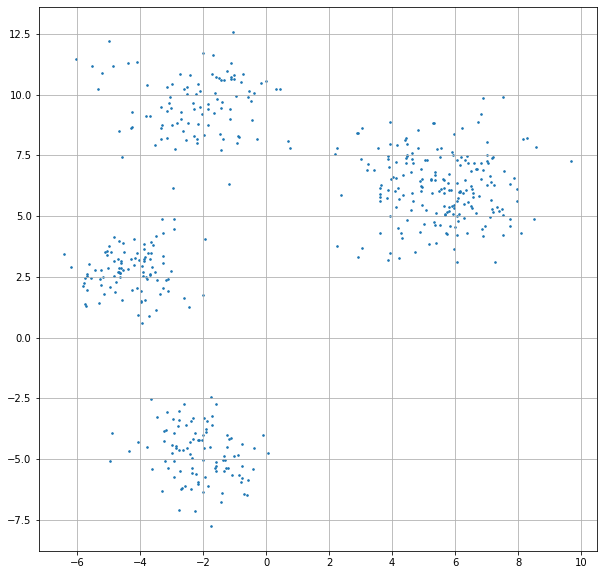

In [3]:
plt.figure(figsize=(10,10))
plt.scatter( x=X[:,0], y=X[:,1], s=10, marker='.' )
plt.grid()

## модель

каждый нейрон первого (распределительного) слоя    
соединен со всеми нейронами второго (выходного) слоя,  
которые расположены в виде двумерной решетки.

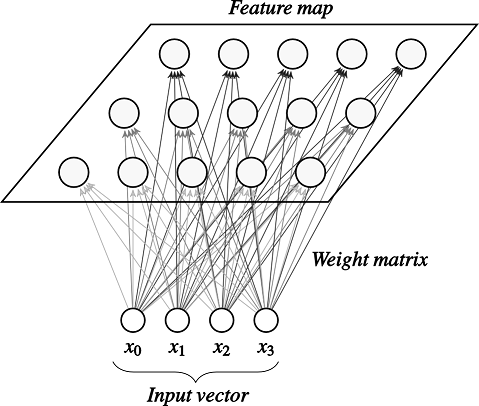

https://www.liveinternet.ru/community/rss_rss_hh_full/post418940841/

$$\|x,w\|+b $$

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

In [5]:
def state(x,w,b): # состояние нейронов
    return euclidean_distances(x,w)+b
    # return x.dot(w.T)+b

def score(x,weight): 
    w,b = weight
    return state(x,w,b)

def predict(x,weight): 
    return np.argmin( score(x,weight), axis=1)
    # return np.argmax( score(x,weight), axis=1)    


In [6]:
# инициализация параметров сети
def weight_init(input_size,output_size):
    out_count = output_size**2 # количество нейронов выходного слоя
    return [
        rng.uniform(size=(out_count,input_size)), # веса
        # np.ones(out_count)/out_count, # сдвиги
        np.zeros(out_count)
    ]

weight = weight_init(input_size=X.shape[1],output_size=2)
# predict(X,weight)

## обучение

WTA: корректировка весов производится только для нейрона-победителя   

$$
w_{ij} := w_{ij} + η (x_i − w_{ij})
$$

In [7]:
# weight

In [8]:
def fit_one(x,weight,lr):
    # определить нейрон-победитель (вектор весов)
    winner = predict(x,weight) 
    
    w,b = weight
    # изменение весов
    dw = np.zeros(w.shape)
    dw[winner] = w[winner]-x
    # изменение сдвигов
    # db = np.zeros(b.shape)
    # db[winner] = exp(1-np.log(c)).-b[winner] 
        
    # return [ w+lr*dw, b+lr*db ]     
    return [ w+lr*dw, np.zeros(b.shape) ] 

In [9]:
def fit_epoch(x,weight,lr):
    for i in rng.permutation(len(x)):
        w = fit_one( x[i][np.newaxis,:], weight, lr) 
    return w        

In [10]:
X_train = X

In [11]:
def msqe(w0,w1):return np.square(w0-w1).sum()/np.prod(w0.shape)  

In [12]:
from tqdm import tqdm

lr=.01
n_epoch = 25

epoch = tqdm(range(n_epoch))
for _ in epoch:
    w = weight[0].copy()
    weight = fit_epoch(X_train,weight,lr)
    epoch.set_postfix({'weight diff':msqe(weight[0],w), })

100%|██████████| 25/25 [00:01<00:00, 16.74it/s, weight diff=0.000492]


## тестируем

In [13]:
p = predict(X_train,weight)

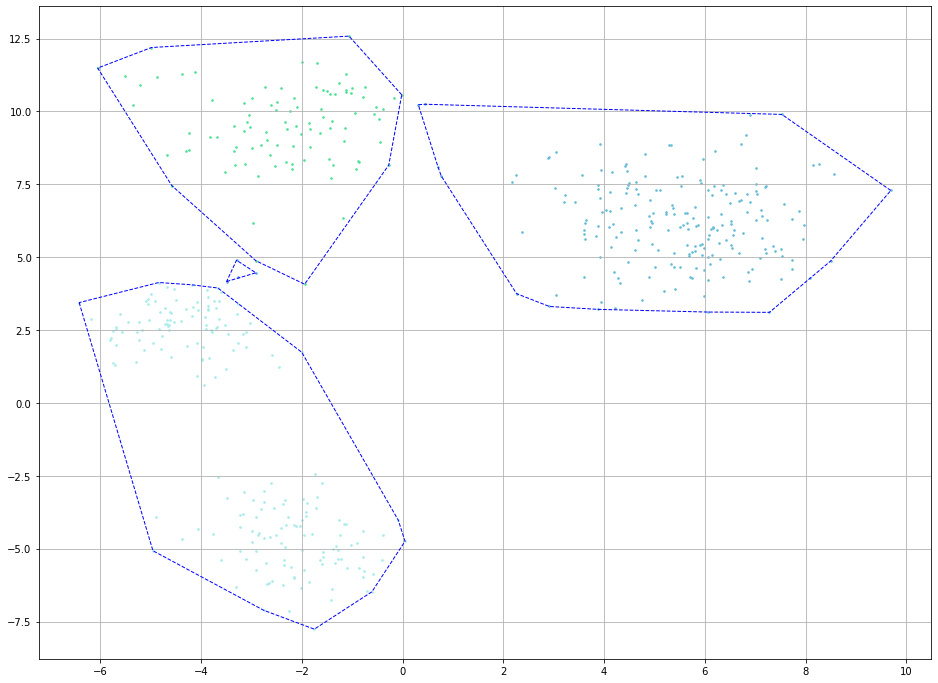

In [14]:
from scipy.spatial import ConvexHull

def hull(x):
    if len(x)<3: return
    hull = ConvexHull(x) # рисуем выпуклую оболочку вокруг кластера
    v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
    plt.plot(x[v,0],x[v,1],'--',lw=1,c='b')

def plot(X,y,figsize=(16,12)):
    plt.figure(figsize=figsize)
    colors = rng.uniform(size=(max(y)+1,3),low=.3,high=1.)
    for j in set(y): 
        plt.scatter( x=X[y==j,0], y=X[y==j,1], s=10, marker='.',c=[colors[j]] )
        hull(X[y==j])
    plt.grid()

    
plot(X,p)

In [15]:
# оценка результата
from sklearn.metrics import silhouette_score

# отношение внутрикластерного и межкластерного расстояний
silhouette_score(X,p)

0.3839126930331453